Expected beat frequency: 175438.60 Hz
Expected Doppler frequency: 320.00 Hz
Target detected at range bin index: 10
Peak Doppler frequency (after windowing): 311.89 Hz
Estimated Doppler frequency from phase slope: 320.00 Hz


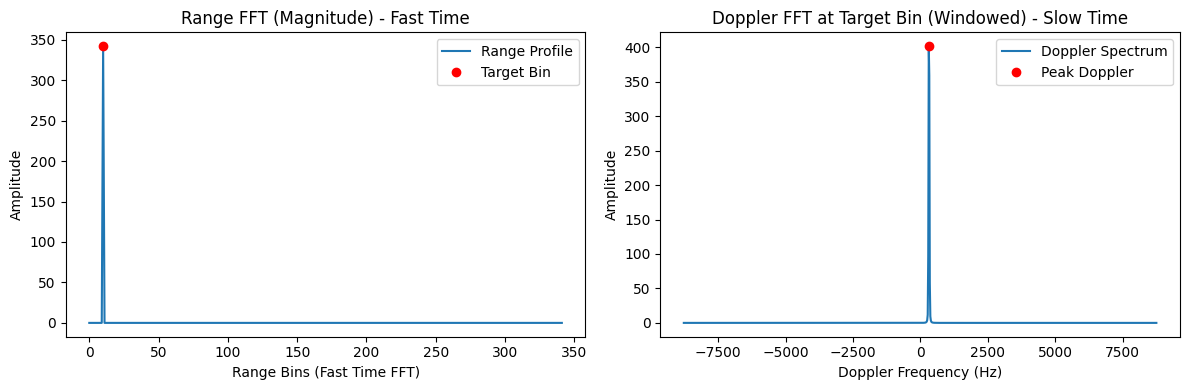

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# SRS
c = 3e8                      # Speed of light (m/s)
B = 1e9                      # Bandwidth = 1 GHz
Tc = 57e-6                   # Chirp time = 57 µs
Fs = 6e6                     # Sampling frequency = 6 MHz
N_fast = int(Fs * Tc)        # Fast time samples (per chirp)
N_slow = 900                 # Slow time samples (chirps per CPI)

R_target = 1.5               # Target at 1.5 meters
v_target = 0.8               # Chest motion velocity (m/s)
f_c = 60e9                   # Radar carrier frequency = 60 GHz

#DERIVED PARAMETERS
S = B / Tc                   # Chirp slope (Hz/s)
tau = 2 * R_target / c       # Round-trip delay
f_beat = S * tau             # Beat frequency (related to range)
f_d = 2 * v_target * f_c / c # Doppler frequency (related to velocity)

print(f"Expected beat frequency: {f_beat:.2f} Hz")
print(f"Expected Doppler frequency: {f_d:.2f} Hz")

# TIME AXIS
t_fast = np.arange(N_fast) / Fs               # Fast time (samples within a chirp)
t_slow = np.arange(N_slow) * Tc               # Slow time (time across chirps)

# -SIGNAL SIMULATION
# Fast time component: beat frequency (range)
# Slow time component: Doppler phase shift (velocity)
doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)  # Shape: (N_slow, 1)
signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))  # Shape: (N_slow, N_fast)

# FAST TIME PROCESSING (RANGE FFT)
range_profiles = np.fft.fft(signal, axis=1)      # FFT across fast time (per chirp)
range_magnitude = np.abs(range_profiles)
target_range_bin = np.argmax(np.mean(range_magnitude, axis=0))
print(f"Target detected at range bin index: {target_range_bin}")

# SLOW TIME PROCESSING (DOPPLER FFT)
doppler_signal = signal[:, target_range_bin]     # Extract signal from target range bin

# Applying window to reduce spectral leakage in Doppler FFT
window = np.hanning(N_slow)
windowed_doppler_signal = doppler_signal * window

doppler_spectrum = np.fft.fftshift(np.fft.fft(windowed_doppler_signal))  # FFT across slow time
doppler_freqs = np.fft.fftshift(np.fft.fftfreq(N_slow, d=Tc))

# Getting peak Doppler frequency from spectrum
peak_doppler_index = np.argmax(np.abs(doppler_spectrum))
peak_doppler_freq = doppler_freqs[peak_doppler_index]
print(f"Peak Doppler frequency (after windowing): {peak_doppler_freq:.2f} Hz")

# PHASE-BASED DOPPLER ESTIMATION
unwrapped_phase = np.unwrap(np.angle(doppler_signal))  # Unwrap phase across slow time
slope, _ = np.polyfit(t_slow, unwrapped_phase, 1)      # Linear fit to phase vs. time
doppler_freq_estimated = slope / (2 * np.pi)           # Convert phase slope to frequency
print(f"Estimated Doppler frequency from phase slope: {doppler_freq_estimated:.2f} Hz")

plt.figure(figsize=(12, 4))

# Range FFT plot (fast time)
plt.subplot(1, 2, 1)
plt.title("Range FFT (Magnitude) - Fast Time")
plt.plot(np.abs(range_profiles[0]), label='Range Profile')
plt.plot(target_range_bin, np.abs(range_profiles[0, target_range_bin]), 'ro', label='Target Bin')
plt.xlabel("Range Bins (Fast Time FFT)")
plt.ylabel("Amplitude")
plt.legend()

# Doppler FFT plot (slow time)
plt.subplot(1, 2, 2)
plt.title("Doppler FFT at Target Bin (Windowed) - Slow Time")
plt.plot(doppler_freqs, np.abs(doppler_spectrum), label='Doppler Spectrum')
plt.plot(peak_doppler_freq, np.abs(doppler_spectrum[peak_doppler_index]), 'ro', label='Peak Doppler')
plt.xlabel("Doppler Frequency (Hz)")
plt.ylabel("Amplitude")
plt.legend()

plt.tight_layout()
plt.show()


Expected beat frequency: 175438.60 Hz
Expected Doppler frequency: 320.00 Hz


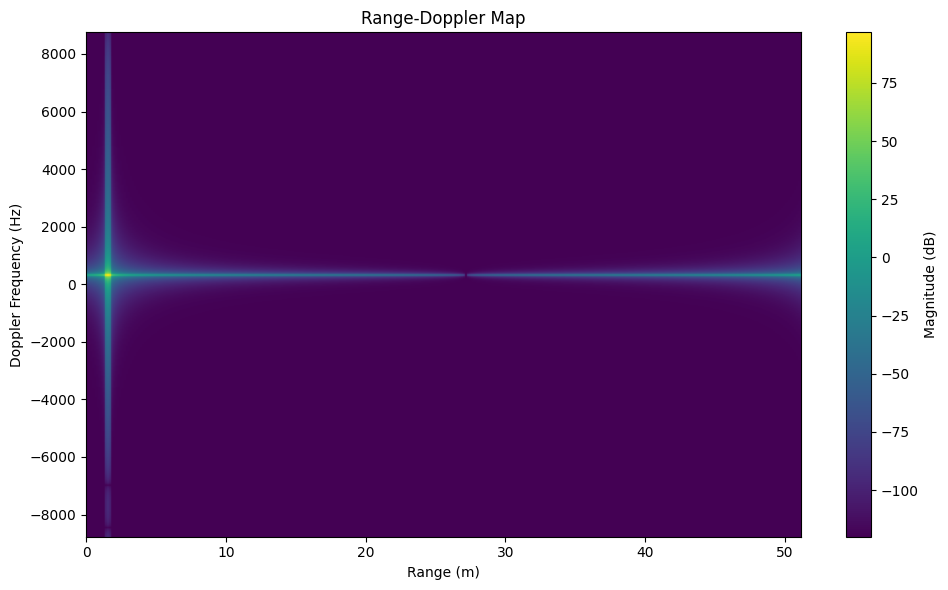

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8                      # Speed of light (m/s)
B = 1e9                      # Bandwidth = 1 GHz
Tc = 57e-6                   # Chirp time = 57 µs
Fs = 6e6                     # Sampling frequency = 6 MHz
N_fast = int(Fs * Tc)        # Fast time samples (per chirp)
N_slow = 900                 # Slow time samples (chirps per CPI)

R_target = 1.5               # Target at 1.5 meters
v_target = 0.8               # Target velocity (m/s)
f_c = 60e9                   # Carrier frequency = 60 GHz

# Derived parameters
S = B / Tc                   # Chirp rate
tau = 2 * R_target / c       # Time delay
f_beat = S * tau             # Beat frequency
f_d = 2 * v_target * f_c / c # Doppler frequency

print(f"Expected beat frequency: {f_beat:.2f} Hz")
print(f"Expected Doppler frequency: {f_d:.2f} Hz")

# Time axes
t_fast = np.arange(N_fast) / Fs          # Fast time (range)
t_slow = np.arange(N_slow) * Tc          # Slow time (Doppler)

# Simulating received signal (2D complex baseband)
doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)
signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))

# Applying 2D Hanning Window
window_fast = np.hanning(N_fast)
window_slow = np.hanning(N_slow)
window_2D = np.outer(window_slow, window_fast)
signal_windowed = signal * window_2D

# Performing Range-Doppler FFT
rdm = np.fft.fftshift(np.fft.fft(signal_windowed, axis=0), axes=0)  # Doppler FFT + shift
rdm = np.fft.fft(rdm, axis=1)                                       # Range FFT (no shift)
rdm_mag = 20 * np.log10(np.abs(rdm) + 1e-6)                          # Convert to dB

# Axes for plotting
range_res = c / (2 * B)                             # Range resolution
range_bins = np.arange(N_fast) * range_res          # Range axis (meters)
doppler_freqs = np.fft.fftshift(np.fft.fftfreq(N_slow, d=Tc))  # Doppler axis (Hz)

# Plotting Range-Doppler Map
plt.figure(figsize=(10, 6))
plt.imshow(rdm_mag, extent=[range_bins[0], range_bins[-1],
                            doppler_freqs[0], doppler_freqs[-1]],
           aspect='auto', cmap='viridis', origin='lower')

plt.title("Range-Doppler Map")
plt.xlabel("Range (m)")
plt.ylabel("Doppler Frequency (Hz)")
plt.colorbar(label="Magnitude (dB)")
plt.tight_layout()
plt.show()


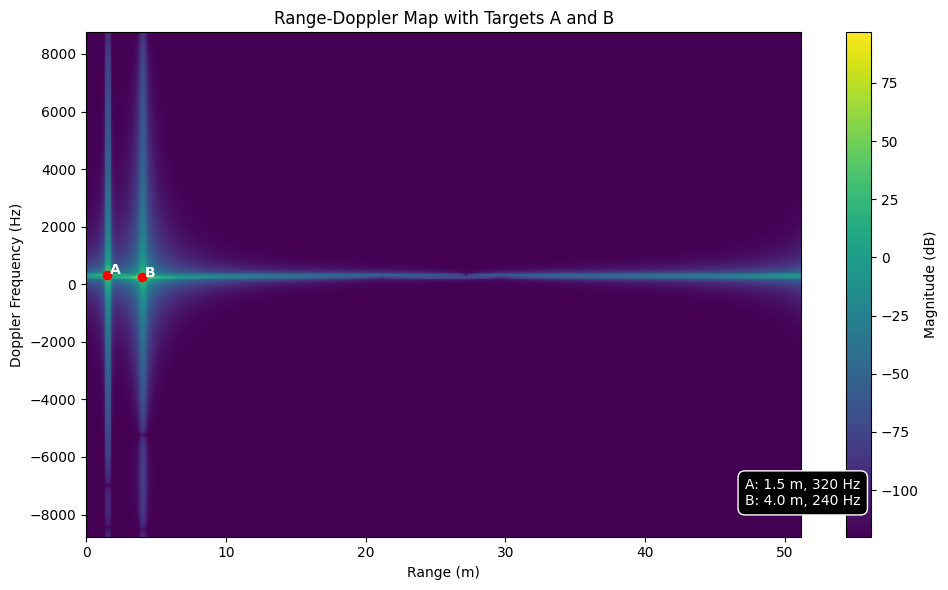

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8
B = 1e9
Tc = 57e-6
Fs = 6e6
N_fast = int(Fs * Tc)
N_slow = 900
f_c = 60e9

# Target Definitions
targets = [
    {"R": 1.5, "v": 0.8, "label": "A"},
    {"R": 4.0, "v": 0.6, "label": "B"}
]

# Time Axes
t_fast = np.arange(N_fast) / Fs
t_slow = np.arange(N_slow) * Tc

# Signal Generation
signal = np.zeros((N_slow, N_fast), dtype=complex)

for target in targets:
    R = target["R"]
    v = target["v"]

    tau = 2 * R / c
    f_beat = B / Tc * tau
    f_d = 2 * v * f_c / c

    doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)
    target_signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))

    signal += target_signal

# Applying 2D Window
window_2D = np.outer(np.hanning(N_slow), np.hanning(N_fast))
signal_windowed = signal * window_2D

# 2D FFT
rdm = np.fft.fftshift(np.fft.fft(signal_windowed, axis=0), axes=0)
rdm = np.fft.fft(rdm, axis=1)
rdm_mag = 20 * np.log10(np.abs(rdm) + 1e-6)

# Axes
range_res = c / (2 * B)
range_bins = np.arange(N_fast) * range_res
doppler_freqs = np.fft.fftshift(np.fft.fftfreq(N_slow, d=Tc))

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(rdm_mag, extent=[range_bins[0], range_bins[-1],
                            doppler_freqs[0], doppler_freqs[-1]],
           aspect='auto', cmap='viridis', origin='lower')

plt.title("Range-Doppler Map with Targets A and B")
plt.xlabel("Range (m)")
plt.ylabel("Doppler Frequency (Hz)")
plt.colorbar(label="Magnitude (dB)")

info_text = ""
for target in targets:
    R = target["R"]
    v = target["v"]
    f_d = 2 * v * f_c / c
    label = target["label"]

    plt.plot(R, f_d, 'ro', markersize=6)
    plt.text(R + 0.2, f_d + 20, label, color='white', fontsize=10, weight='bold')

    info_text += f"{label}: {R} m, {int(f_d)} Hz\n"

plt.gcf().text(0.75, 0.15, info_text.strip(), fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", fc="black", ec="white", lw=1),
               color='white')

plt.tight_layout()
plt.show()


In [53]:
import numpy as np

# Constants
c = 3e8
f_c = 60e9
λ = c / f_c
d = λ / 2

# Radar Parameters
B = 1e9
Tc = 57e-6
Fs = 6e6
N_fast = int(Fs * Tc)
N_slow = 900
S = B / Tc

t_fast = np.arange(N_fast) / Fs
t_slow = np.arange(N_slow) * Tc

# Defining targets: [range, velocity, angle]
targets = [
    {"R": 1.5, "v": 0.8, "angle": 20},   # Target A
    {"R": 4.0, "v": 0.6, "angle": -30}   # Target B
]

for i, tgt in enumerate(targets):
    # Initializing Rx signals for this target only
    Rx1 = np.zeros((N_slow, N_fast), dtype=complex)
    Rx2 = np.zeros((N_slow, N_fast), dtype=complex)

    tau = 2 * tgt["R"] / c
    f_beat = S * tau
    f_d = 2 * tgt["v"] * f_c / c
    aoa_phase = 2 * np.pi * d * np.sin(np.deg2rad(tgt["angle"])) / λ
    doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)

    signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))
    Rx1 = signal
    Rx2 = signal * np.exp(1j * aoa_phase)

    # Range FFT
    range_profiles = np.fft.fft(Rx1, axis=1)
    range_magnitude = np.abs(range_profiles)
    target_bin = int(f_beat * N_fast / Fs)

    # AoA Estimation
    sig1 = Rx1[:, target_bin]
    sig2 = Rx2[:, target_bin]
    phase_diff = np.angle(sig2 * np.conj(sig1))
    mean_phase_diff = np.mean(np.unwrap(phase_diff))
    est_angle = np.arcsin(mean_phase_diff * λ / (2 * np.pi * d)) * 180 / np.pi

    print(f"--- Target {chr(65+i)} ---")
    print(f"True AoA: {tgt['angle']}°")
    print(f"Estimated AoA: {est_angle:.2f}°")
    print(f"Range bin used: {target_bin}")
    print(f"Phase difference (rad): {mean_phase_diff:.4f}")
    print()


--- Target A ---
True AoA: 20°
Estimated AoA: 20.00°
Range bin used: 10
Phase difference (rad): 1.0745

--- Target B ---
True AoA: -30°
Estimated AoA: -30.00°
Range bin used: 26
Phase difference (rad): -1.5708



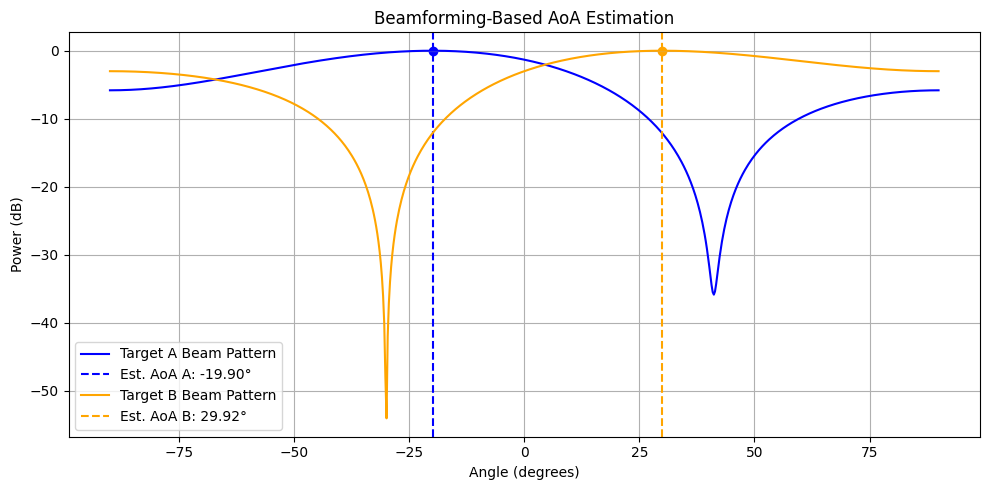

Estimated AoA for Target A: -19.90° (True: 20°)
Estimated AoA for Target B: 29.92° (True: -30°)


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8
f_c = 60e9
λ = c / f_c
d = λ / 2

# Radar Parameters
B = 1e9
Tc = 57e-6
Fs = 6e6
N_fast = int(Fs * Tc)
N_slow = 900
S = B / Tc

# Time vectors
t_fast = np.arange(N_fast) / Fs
t_slow = np.arange(N_slow) * Tc

# Defining targets
targets = [
    {"R": 1.5, "v": 0.8, "angle": 20},   # Target A
    {"R": 4.0, "v": 0.6, "angle": -30}   # Target B
]

# Simulating received signals
Rx1 = np.zeros((N_slow, N_fast), dtype=complex)
Rx2 = np.zeros((N_slow, N_fast), dtype=complex)

for tgt in targets:
    tau = 2 * tgt["R"] / c
    f_beat = S * tau
    f_d = 2 * tgt["v"] * f_c / c
    aoa_phase = 2 * np.pi * d * np.sin(np.deg2rad(tgt["angle"])) / λ
    doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)
    signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))
    Rx1 += signal
    Rx2 += signal * np.exp(1j * aoa_phase)

# FFT across fast time (Range FFT)
range_profiles1 = np.fft.fft(Rx1, axis=1)
range_profiles2 = np.fft.fft(Rx2, axis=1)

# Estimating expected range bin indices
target_bins = [int(S * (2 * tgt["R"] / c) / Fs * N_fast) for tgt in targets]

# Angle scanning
angles = np.linspace(-90, 90, 720)
steering_vec = lambda theta: np.array([1, np.exp(-1j * 2 * np.pi * d * np.sin(np.deg2rad(theta)) / λ)])

plt.figure(figsize=(10, 5))
colors = ['blue', 'orange']
estimated_angles = []

for i, bin_idx in enumerate(target_bins):
    x1 = range_profiles1[:, bin_idx]
    x2 = range_profiles2[:, bin_idx]
    x = np.stack([x1, x2], axis=0)

    power_response = []
    for theta in angles:
        a = steering_vec(theta)[:, np.newaxis]
        beam = np.abs((a.conj().T @ x)**2).mean()
        power_response.append(beam)

    power_response = 10 * np.log10(np.abs(power_response) / np.max(np.abs(power_response)))
    peak_idx = np.argmax(power_response)
    est_angle = angles[peak_idx]
    estimated_angles.append(est_angle)

    plt.plot(angles, power_response, label=f'Target {chr(65+i)} Beam Pattern', color=colors[i])
    plt.axvline(x=est_angle, color=colors[i], linestyle='--', label=f'Est. AoA {chr(65+i)}: {est_angle:.2f}°')
    plt.scatter(est_angle, power_response[peak_idx], color=colors[i])

plt.title("Beamforming-Based AoA Estimation")
plt.xlabel("Angle (degrees)")
plt.ylabel("Power (dB)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Print results
for i, est_angle in enumerate(estimated_angles):
    print(f"Estimated AoA for Target {chr(65+i)}: {est_angle:.2f}° (True: {targets[i]['angle']}°)")


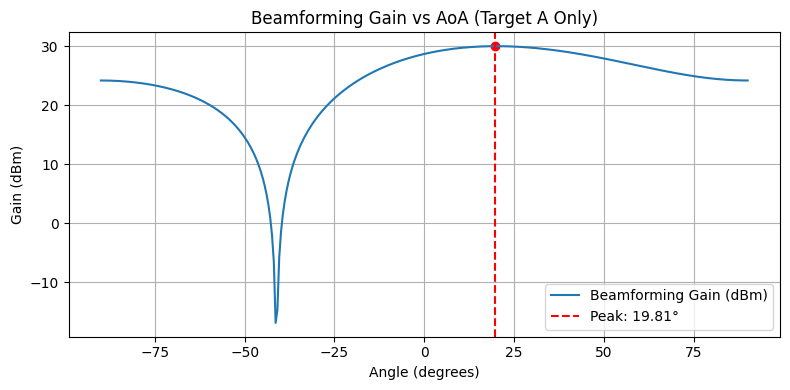

Maximum Beamforming Gain: 30.00 dBm at 19.81°


In [58]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8
f_c = 60e9
λ = c / f_c
d = λ / 2

# Radar Parameters
B = 1e9
Tc = 57e-6
Fs = 6e6
N_fast = int(Fs * Tc)
N_slow = 900
S = B / Tc

t_fast = np.arange(N_fast) / Fs
t_slow = np.arange(N_slow) * Tc

# Target A only
target = {"R": 1.5, "v": 0.8, "angle": 20}

# Simulating Rx signals
Rx1 = np.zeros((N_slow, N_fast), dtype=complex)
Rx2 = np.zeros((N_slow, N_fast), dtype=complex)

tau = 2 * target["R"] / c
f_beat = S * tau
f_d = 2 * target["v"] * f_c / c
aoa_phase = 2 * np.pi * d * np.sin(np.deg2rad(target["angle"])) / λ
doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)
signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))
Rx1 += signal
Rx2 += signal * np.exp(1j * aoa_phase)

# Range FFT
range_profiles = np.fft.fft(Rx1, axis=1)
range_magnitude = np.abs(range_profiles)
range_bin = np.argmax(np.mean(range_magnitude, axis=0))

# Extract signals at range bin
sig1 = Rx1[:, range_bin]
sig2 = Rx2[:, range_bin]

# Beamforming over AoA sweep
angles = np.linspace(-90, 90, 360)
gains = []

for theta in angles:
    weight = np.array([1, np.exp(-1j * 2 * np.pi * d * np.sin(np.deg2rad(theta)) / λ)])
    beamformed = weight[0] * sig1 + weight[1] * sig2
    power = np.abs(np.sum(beamformed)) ** 2
    gains.append(power)

gains_db = 10 * np.log10(np.array(gains) / np.max(gains)) + 30  # Normalized to 30 dBm

# Finding peak
peak_idx = np.argmax(gains_db)
peak_angle = angles[peak_idx]
peak_gain = gains_db[peak_idx]

# Plot
plt.figure(figsize=(8, 4))
plt.plot(angles, gains_db, label="Beamforming Gain (dBm)")
plt.axvline(peak_angle, color='r', linestyle='--', label=f'Peak: {peak_angle:.2f}°')
plt.scatter(peak_angle, peak_gain, color='red')
plt.title("Beamforming Gain vs AoA (Target A Only)")
plt.xlabel("Angle (degrees)")
plt.ylabel("Gain (dBm)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Maximum Beamforming Gain: {peak_gain:.2f} dBm at {peak_angle:.2f}°")


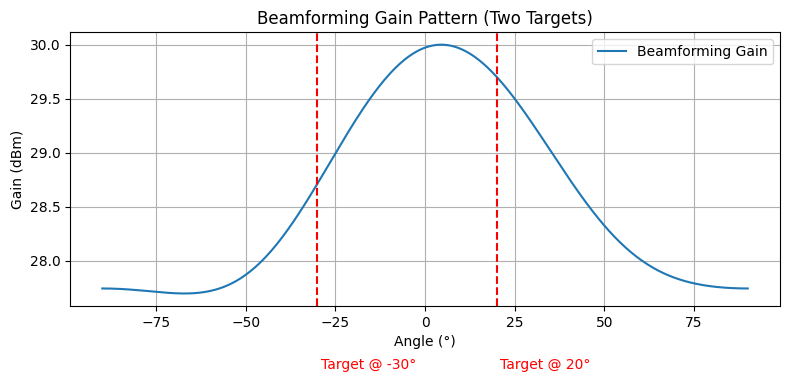

Beamforming Gain at 20°: 29.71 dBm
Beamforming Gain at -30°: 28.72 dBm


In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
c = 3e8
f_c = 60e9
λ = c / f_c
d = λ / 2

# Radar Parameters
B = 1e9
Tc = 57e-6
Fs = 6e6
N_fast = int(Fs * Tc)
N_slow = 900
S = B / Tc

t_fast = np.arange(N_fast) / Fs
t_slow = np.arange(N_slow) * Tc

# Defining targets
targets = [
    {"R": 1.5, "v": 0.8, "angle": 20},    # Target A
    {"R": 4.0, "v": 0.6, "angle": -30}    # Target B
]

# Simulating Rx signals
Rx1 = np.zeros((N_slow, N_fast), dtype=complex)
Rx2 = np.zeros((N_slow, N_fast), dtype=complex)

for tgt in targets:
    tau = 2 * tgt["R"] / c
    f_beat = S * tau
    f_d = 2 * tgt["v"] * f_c / c
    aoa_phase = 2 * np.pi * d * np.sin(np.deg2rad(tgt["angle"])) / λ
    doppler_phase = 2 * np.pi * f_d * t_slow.reshape(-1, 1)
    signal = np.exp(1j * (2 * np.pi * f_beat * t_fast + doppler_phase))
    Rx1 += signal
    Rx2 += signal * np.exp(1j * aoa_phase)

# Using Range FFT to find bins
range_profiles = np.fft.fft(Rx1, axis=1)
range_magnitude = np.abs(range_profiles)
range_bins = np.argmax(np.mean(range_magnitude, axis=0))

# Getting target-specific bins
target_bins = [int(S * (2 * tgt["R"] / c) / Fs * N_fast) for tgt in targets]

# Beamforming over angle sweep
angles = np.linspace(-90, 90, 360)
gains = []

for theta in angles:
    steering_vector = np.array([1, np.exp(-1j * 2 * np.pi * d * np.sin(np.deg2rad(theta)) / λ)])
    gain = 0
    for bin_idx in target_bins:
        snapshot = np.stack([Rx1[:, bin_idx], Rx2[:, bin_idx]], axis=0)
        beamformed = np.conj(steering_vector) @ snapshot
        gain += np.abs(beamformed) ** 2
    gains.append(np.sum(gain))

# Converting to dBm
gains_dbm = 10 * np.log10(np.array(gains) / np.max(gains)) + 30  # Normalizing then converting

# Ploting beam pattern
plt.figure(figsize=(8, 4))
plt.plot(angles, gains_dbm, label='Beamforming Gain')
plt.title("Beamforming Gain Pattern (Two Targets)")
plt.xlabel("Angle (°)")
plt.ylabel("Gain (dBm)")
plt.grid(True)

# Annotating expected AoAs
for tgt in targets:
    plt.axvline(x=tgt["angle"], color='r', linestyle='--')
    plt.text(tgt["angle"] + 1, np.max(gains_dbm) - 3,
             f"Target @ {tgt['angle']}°", color='red')

plt.tight_layout()
plt.legend()
plt.show()

# Printing gain at each target AoA
for tgt in targets:
    idx = np.argmin(np.abs(angles - tgt["angle"]))
    print(f"Beamforming Gain at {tgt['angle']}°: {gains_dbm[idx]:.2f} dBm")


In [64]:
θ = 20  # degrees
ψ = 2 * np.pi * d * np.sin(np.deg2rad(θ)) / λ
a = np.array([1, np.exp(-1j * ψ)])


This vector aligns with signals coming from target_angle.

In [65]:
bin_idx = target_bins[0]
snapshot = np.stack([Rx1[:, bin_idx], Rx2[:, bin_idx]], axis=0)


This is the received signal at both antennas for the range bin where the target is located.

In [66]:
beam = np.conj(a) @ snapshot

This step projects the received signal onto the steering vector — it’s the key operation in delay-and-sum beamforming.

In [67]:
gain = np.sum(np.abs(beam) ** 2)
gain_dbm = 10 * np.log10(gain / np.max(gains)) + 30
print(f"Manual gain at {θ}°: {gain_dbm:.2f} dBm")

Manual gain at 20°: 26.66 dBm


SNR per chirp: -1.07 dB (0.781628 Watt)
Coherent Integration Gain: 29.54 dB
SNR after coherent integration over 900 chirps: 28.47 dB


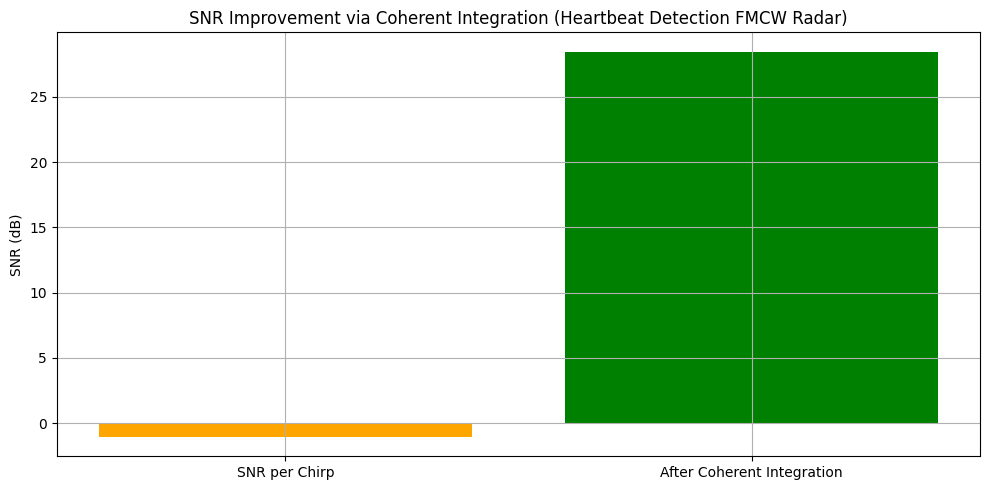

In [80]:
import numpy as np
import matplotlib.pyplot as plt

num_chirps = 900                  # Number of chirps in CPI
chirp_duration = 57e-6            # Chirp duration (Tc) in seconds
sampling_freq = 6e6               # Sampling frequency in Hz
rcs = 0.005                       # Average Radar Cross Section (RCS) in m^2
target_range = 1.5                # Assume average range to target in meters
tx_power_dbm = 12                 # Transmit power in dBm
tx_power_watt = 10 ** ((tx_power_dbm - 30) / 10)  # Convert dBm to Watts
wavelength = 3e8 / 60e9           # Wavelength at 60 GHz
gain_tx = 10                      # Transmit antenna gain (linear)
gain_rx = 10                      # Receive antenna gain (linear)

# Calculating received power using radar equation
def received_power(Pt, Gt, Gr, λ, σ, R):
    return (Pt * Gt * Gr * λ**2 * σ) / ((4 * np.pi)**3 * R**4)

rx_power = received_power(tx_power_watt, gain_tx, gain_rx, wavelength, rcs, target_range)

# Assuming noise figure and bandwidth
noise_figure_db = 8
noise_figure = 10 ** (noise_figure_db / 10)
bandwidth = 1e9  # 1 GHz
k = 1.38e-23     # Boltzmann constant
T = 290          # Temperature in Kelvin

# Noise power
noise_power = k * T * bandwidth * noise_figure

# SNR per chirp (linear and dB)
snr_per_chirp = rx_power / noise_power
snr_per_chirp_db = 10 * np.log10(snr_per_chirp)

# Coherent integration gain (theoretical)
coherent_gain_db = 10 * np.log10(num_chirps)
snr_after_db = snr_per_chirp_db + coherent_gain_db

# Print SNR values
print(f"SNR per chirp: {snr_per_chirp_db:.2f} dB (0.781628 Watt)")
print(f"Coherent Integration Gain: {coherent_gain_db:.2f} dB")
print(f"SNR after coherent integration over {num_chirps} chirps: {snr_after_db:.2f} dB")


plt.figure(figsize=(10, 5))
plt.bar(['SNR per Chirp', 'After Coherent Integration'],
        [snr_per_chirp_db, snr_after_db],
        color=['orange', 'green'])

plt.title('SNR Improvement via Coherent Integration (Heartbeat Detection FMCW Radar)')
plt.ylabel('SNR (dB)')
plt.grid(True)
plt.tight_layout()
plt.show()


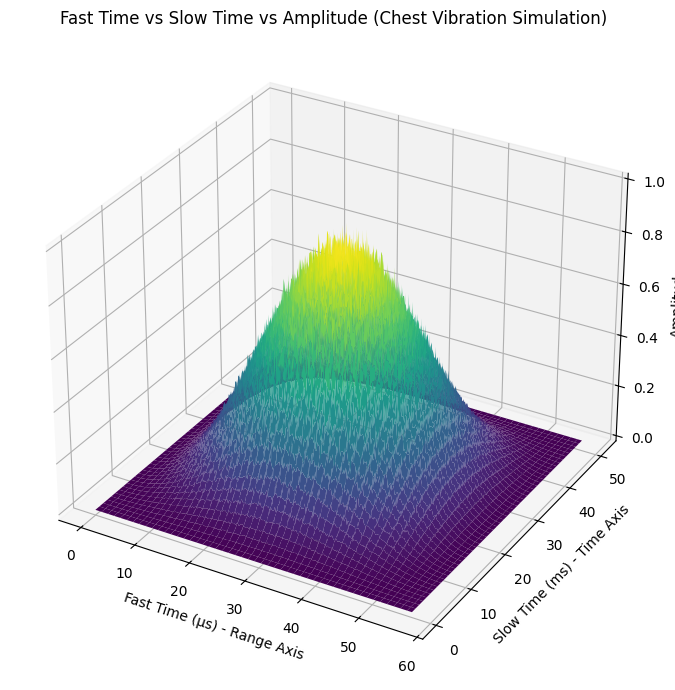

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Radar parameters
Fs = 6e6                      # Sampling rate (Hz)
Tc = 57e-6                    # Chirp duration (sec)
N_fast = int(Fs * Tc)        # Fast time samples (per chirp)
N_slow = 900                 # Number of chirps (slow time)
f_c = 60e9                   # Carrier frequency (Hz)
c = 3e8                      # Speed of light (m/s)
lambda_c = c / f_c           # Wavelength

# Time axes
t_fast = np.arange(N_fast) / Fs
t_slow = np.arange(N_slow) * Tc

# Simulated chest motion: respiration + heartbeat
respiration_freq = 0.25
heartbeat_freq = 1.2
chest_motion = 0.002 * np.sin(2 * np.pi * respiration_freq * t_slow) + \
               0.001 * np.sin(2 * np.pi * heartbeat_freq * t_slow)

# Phase modulation from chest movement
R = 1.2  # baseline range
phase_mod = 4 * np.pi * (R + chest_motion) / lambda_c

# Simulated FMCW signal
f_beat = 2 * (R / c) * (1e9 / Tc)
signal_fast = np.exp(1j * 2 * np.pi * f_beat * t_fast)

# Constructing full signal
signal = np.zeros((N_slow, N_fast), dtype=complex)
for i, phi in enumerate(phase_mod):
    signal[i, :] = signal_fast * np.exp(1j * phi)

# Adding noise
noise = 0.05 * (np.random.randn(N_slow, N_fast) + 1j * np.random.randn(N_slow, N_fast))
signal += noise

# Applying 2D Hanning window
window_2d = np.outer(np.hanning(N_slow), np.hanning(N_fast))
signal_windowed = signal * window_2d

# Normalizing
amplitude = np.abs(signal_windowed)
amplitude /= np.max(amplitude)


X, Y = np.meshgrid(t_fast * 1e6, t_slow * 1e3)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, amplitude, cmap='viridis')
ax.set_xlabel("Fast Time (µs) - Range Axis")
ax.set_ylabel("Slow Time (ms) - Time Axis")
ax.set_zlabel("Amplitude")
ax.set_title("Fast Time vs Slow Time vs Amplitude (Chest Vibration Simulation)")
plt.tight_layout()
plt.show()


In [2]:
import numpy as np
from random import randint
import matplotlib.pyplot as plt
from scipy import signal
from scipy.constants import c, pi, mph
from numpy.fft import fft, fftshift, fft2
from matplotlib import cm
# Radar setup
f = 60e9  # Hz
Tc = 57e-6  # chirp time - s
bw = 1e9  # bandwidth - Hz
chirp_rate = bw / Tc  # Hz/s

wavelength = c / f
M = 900  # number of chirps in coherent processing interval (CPI)

# Target
R = 1.5  # m
v = 0.8  # m/s

In [3]:
range_resolution = c / (2 * bw)
print(f"Range resolution: {range_resolution:.2f} m")

Range resolution: 0.15 m


In [4]:
time_from_dist = R / c
time_from_vel = 2 * (v * Tc) / c
time_elapsed = time_from_vel + time_from_dist
print(f"Propagation time: {time_elapsed * 1e9:.2f} ns")

Propagation time: 5.00 ns


In [5]:
def compute_phase_diff(v):
    time_from_vel = 2 * (v * Tc) / c
    return 2 * pi * f * time_from_vel


def compute_f_beat(R):
    return (2 * R * bw) / (c * Tc)


f_beat = compute_f_beat(R) # Hz
phase_diff = compute_phase_diff(v) # radians

print(f"Beat frequency: {f_beat/1e6:.2f} MHz")
print(f"Phase delta: {phase_diff:.2f} radians")

Beat frequency: 0.18 MHz
Phase delta: 0.11 radians


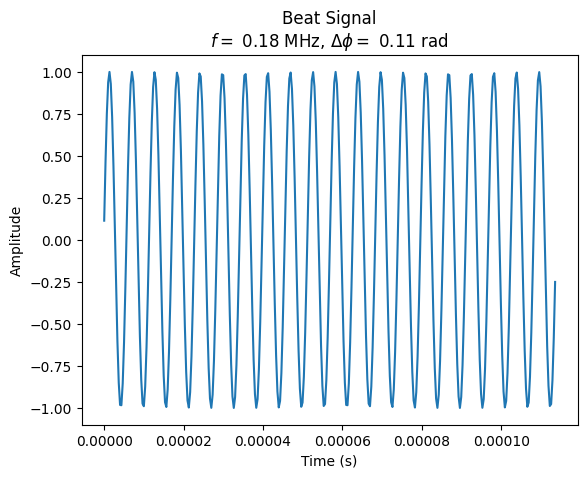

In [6]:
max_time = 20 / f_beat # s
N = 342
Ts = max_time / N # s
fs = 1 / Ts # Hz

t = np.arange(0, max_time, 1 / fs)

beat_signal = np.sin(2 * pi * compute_f_beat(R) * t + phase_diff)

plt.plot(t, beat_signal)
plt.title(
    f"Beat Signal\n"
    f"$f=\\ ${f_beat/1e6:.2f} MHz, $\\Delta \\phi =\\ ${phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

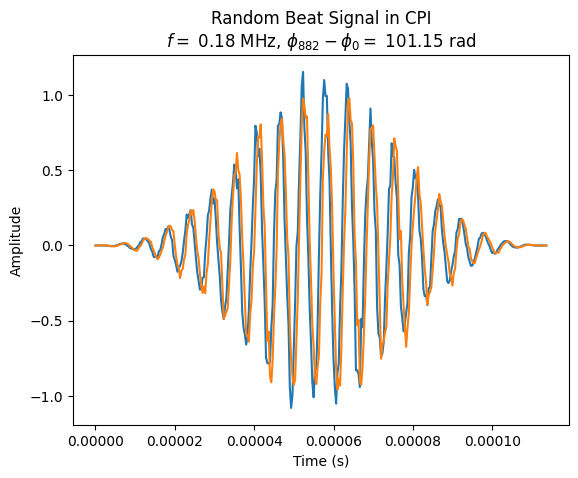

In [7]:
window = signal.windows.blackman(N)
cpi_single = np.array(
    [
        (
            np.sin(2 * pi * compute_f_beat(R) * t + m * phase_diff)
            + np.random.normal(0, 0.1, N)
        )
        * window
        for m in range(M)
    ]
)

n = randint(0, M - 1)

plt.plot(t, cpi_single[n])
plt.plot(t, cpi_single[0])
plt.title(
    f"Random Beat Signal in CPI\n"
    f"$f=\\ ${f_beat/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff:.2f} rad"
)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

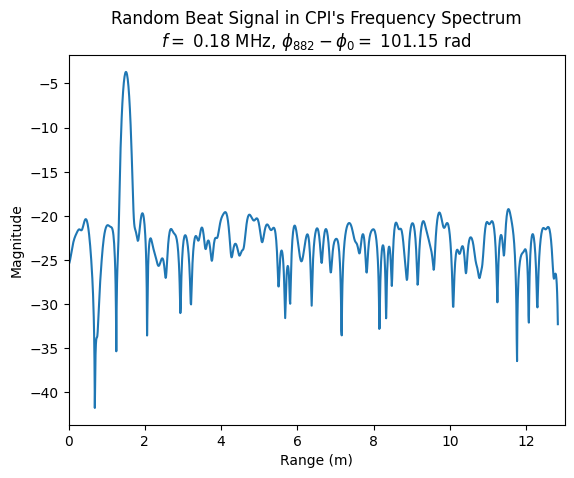

In [8]:
fft_len = N * 8
freq = np.linspace(-fs / 2, fs / 2, fft_len)

rmax = c * Tc * fs / (2 * bw)
n_ranges = np.linspace(-rmax / 2, rmax / 2, N)
ranges = np.linspace(-rmax / 2, rmax / 2, fft_len)

X_k = fftshift(fft(cpi_single[n], fft_len))
X_k /= N / 2
X_k = np.abs(X_k)
X_k = 10 * np.log10(X_k)

fig, ax = plt.subplots()
ax.set_title(
    f"Random Beat Signal in CPI's Frequency Spectrum\n"
    f"$f=\\ ${f_beat/1e6:.2f} MHz, $\\phi_{{{n}}} - \\phi_0 =\\ ${n*phase_diff:.2f} rad"
)

ax.plot(ranges, X_k)
ax.set_xlabel("Range (m)")

ax.set_ylabel("Magnitude")
ax.set_xlim([0, 13])
plt.show()

In [14]:
def db_to_lin(x):
    return 10 ** (x / 10)

In [15]:
targets = [
    (1.5, 0.8, 0),  # Target 1 @ 1.5 m with a velocity of 0.8 m/s and 0 dB relative power
    (4, 0.6, -5)  # Target 2 @ 4 m with a velocity of 0.6 m/s and -5 dB relative power
     # Target 3 @ 10 m with a velocity of 5 m/s and -10 dB relative power
]

sep = "\n\t"
print(
    f"Targets:",
    sep
    + sep.join(
        [
            f"{idx}: distance = {r:.2f} m, velocity = {v:.2f} m/s, relative power = {p:.1f} dB"
            for idx, (r, v, p) in enumerate(targets, start=1)
        ]
    ),
)

Targets: 
	1: distance = 1.50 m, velocity = 0.80 m/s, relative power = 0.0 dB
	2: distance = 4.00 m, velocity = 0.60 m/s, relative power = -5.0 dB


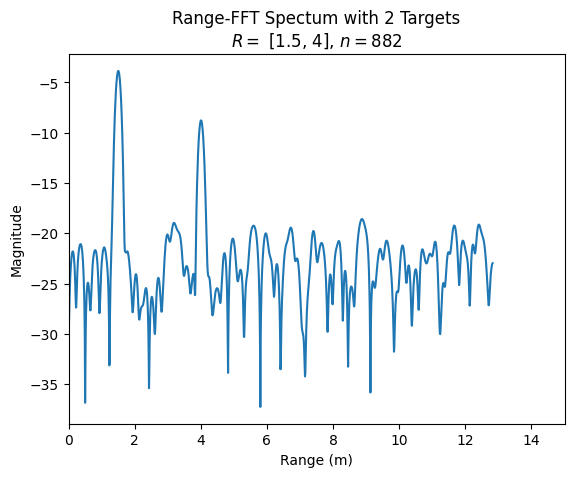

In [16]:
cpi = np.array(
    [
        (
            np.sum(
                [
                    np.sin(2 * pi * compute_f_beat(r) * t + m * compute_phase_diff(v))
                    * db_to_lin(p)
                    for r, v, p in targets
                ],
                axis=0,
            )
            + np.random.normal(0, 0.1, N)
        )
        * window
        for m in range(M)
    ]
)
cpi_range_ffts = fft(cpi, n=fft_len, axis=1)
X_k = fftshift(cpi_range_ffts[n])
X_k /= N / 2
X_k = np.abs(X_k)
X_k = 10 * np.log10(X_k)

fig, ax = plt.subplots()
ax.set_title(
    f"Range-FFT Spectum with 2 Targets\n"
    f"$R =\\ $[{', '.join([str(r) for r, v,p in targets])}], $n = {n}$"
)

ax.plot(ranges, X_k)
ax.set_xlabel("Range (m)")
ax.set_ylabel("Magnitude")
ax.set_xlim([0, 15])
plt.show()